In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [37]:
import tensorflow as tf
import os
import random
import numpy as np
import keras.backend as K
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from tqdm import tqdm

from tensorflow.keras.callbacks import TensorBoard
from skimage.io import imread, imshow , imsave
from skimage.transform import resize
from skimage.color import  gray2rgb, rgb2gray
import matplotlib.pyplot as plt

In [38]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
dict_data=load('/content/drive/My Drive/Colab Notebooks/data.npz')

X_train = dict_data['arr_0']
Y_train = dict_data['arr_1']
edgemap = dict_data['arr_2']
X_val = dict_data['arr_3']
Y_val = dict_data['arr_4']
X_test = dict_data['arr_5']
print(X_train.shape)
print(Y_train.shape)
print(edgemap.shape)
train_length = 28280
val_length = 5000
test_length = 5000

In [40]:
model1 = tf.keras.models.load_model('/content/Edge_Net_without_RELU.h5')
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 1)       33        
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [41]:
model1.layers[0]._name='zero'
model1.layers[1]._name='first'
model1.layers[2]._name='second'
model1.layers[3]._name='third'

lambda1=1
lambda2=0.5
lambda3=0.25

In [42]:
def loss_fn(y_true,y_predict):
  y_true=tf.cast(y_true,tf.float32)
  y_predict=tf.cast(y_predict,tf.float32)
  
  
  # for layers 1  (128,128,16)
  layer_output1=model1.get_layer('first').output
  
  model_layer1=tf.keras.models.Model(inputs=model1.input,outputs=layer_output1)
  
  E1_hat=model_layer1(y_predict)
  E1=model_layer1(y_true)
  
  diff1=tf.keras.backend.abs(E1_hat-E1)
  
  # for layers 2 (128,128,32)
  layer_output2=model1.get_layer('second').output
  model_layer2=tf.keras.models.Model(inputs=model1.input,outputs=layer_output2)
  E2_hat=model_layer2(y_predict)
  E2=model_layer2(y_true)
  diff2=tf.keras.backend.abs(E2_hat-E2)
  

  #for output layer (128,128,1)
  E3_hat=model1(y_predict)
  E3=model1(y_true)
  diff3=tf.keras.backend.abs(E3_hat-E3)
  
  
  #total loss
  sum1=(lambda1*tf.reduce_sum(diff1))  + (lambda2*tf.reduce_sum(diff2))+(lambda3*tf.reduce_sum(diff3))
  
  
  sum2=tf.keras.losses.binary_crossentropy(y_true,y_predict)
  sum2=sum2+sum1

  return sum2

In [43]:
model2 = tf.keras.models.load_model('/content/model_unet.h5')
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [44]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


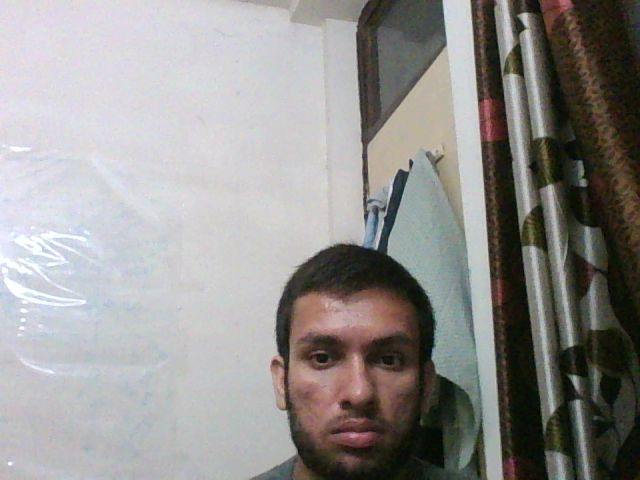

In [45]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

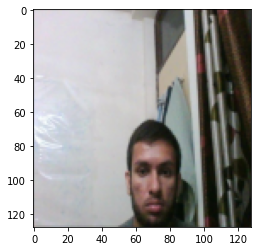

In [46]:
img=imread('/content/photo.jpg')
img=resize(img, (128,128), mode='constant' , preserve_range=True)
img=tf.cast(img,dtype=np.uint8)
img=tf.reshape(img, (1,128,128,3))
plt.imshow(img[0])

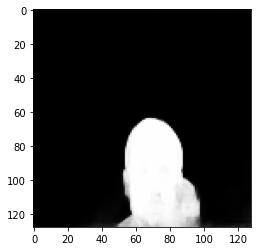

In [47]:
yhat=model2.predict(img)
yhat = gray2rgb(yhat)   #Comment this line for Gray Scale Image
plt.imshow(np.squeeze(yhat[0]))

In [ ]:
img=np.squeeze(yhat[0])
imsave('./Converted_photo.jpg', img)